In [1]:
import os
#os.environ["MKL_THREADING_LAYER"]="GNU"
os.environ["MKL_NUM_THREADS"] = "2" 
os.environ["NUMEXPR_NUM_THREADS"] = "2" 
os.environ["OMP_NUM_THREADS"] = "2" 
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft
import theano.tensor.signal.conv

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[maskJ], delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), magerr_ref1[maskJ],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
#J band data
xJ=np.asarray(mjd_obs[maskJ], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), dtype=float)
yJerr = np.array(magerr_ref1[maskJ], dtype=float)

#H band data
maskH = (filt == 'H')

xHtemp=np.asarray(mjd_obs[maskH], dtype=float)
xH=np.delete(xHtemp,(1,2))
nH=len(xH)
XH = np.reshape(xH,(nH,1))
XH_new=np.linspace(min(XH),max(XH),100,dtype=np.float64)

Hdelta_mag_agn_ref1=np.delete(delta_mag_agn_ref1[maskH],(1,2))
yH=np.asarray(Hdelta_mag_agn_ref1-np.median(Hdelta_mag_agn_ref1), dtype=float)
yHerrtemp = np.asarray(magerr_ref1[maskH], dtype=float)
yHerr=np.delete(yHerrtemp,(1,2))

#K band data
maskK = (filt == 'K')
xK=np.asarray(mjd_obs[maskK], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK]-np.median(delta_mag_agn_ref1[maskK]), dtype=float)
yKerr = np.asarray(magerr_ref1[maskK], dtype=float)

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK),axis=None)
Y_tot=np.reshape(Y_tot,(len(Y_tot),1))

#time delay array
ntau=99
tau=np.linspace(0.0,200.0,ntau)
#tau=np.reshape(tau,(1,1,ntau,1))

In [3]:
sigma_DT=       0.324
m_DT     =     54.116
theta_DT  =   0.0
Jsigma_AD  =    2.175
Jtheta_AD   =  0.0
Jm_AD        = 68.891
T             = np.exp(7.421)
K_0            =0.838
index          =1.148
#REMEMBER T is EXP

#Different wavelength for different bands, not a free paramter 
#REMIR filters in nm NEED DATASHEET
Jwav=1250.0 

#Define constants 
wav_0 = 1122.4#Reference wavelength in nm, use 500?
h = 6.626e-34#Plancks constant in J*s
c = 299792458.0#speed of light in m/s
k = 1.38e-23#Boltzmanns constant in J/K
    
#peak Black Body from uniform torus temperature
wav_peak = 2.898*10**6/T
b_max = h*c/(1e-9*wav_peak*k*T)
BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
#Universal lognormal for Dusty Torus 
exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
lognorm_DT = front_DT*np.exp(exp_DT)
where_are_NaNs1 = np.isnan(lognorm_DT)
lognorm_DT[where_are_NaNs1] = 0.0
    
#Dusty Torus transfer equation for J band
Jb = h*c/(1e-9*Jwav*k*T)
JBB = (1.0/( Jwav**5 * (np.exp(Jb) - 1.0) ))/BB_max
JPsi_DT = JBB*lognorm_DT
    
#Accretion Disk transfer equation for the J band
Jpowr = K_0*(Jwav/wav_0)**(index)    
Jexp_AD = -((np.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
Jlognorm_AD = Jfront_AD*np.exp(Jexp_AD)
where_are_NaNs2 = np.isnan(Jlognorm_AD)
Jlognorm_AD[where_are_NaNs2] = 0.0
JPsi_AD = Jpowr*Jlognorm_AD

#Full transfer equations
Jtransfer = JPsi_DT + JPsi_AD

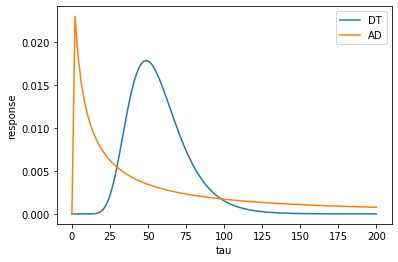

In [4]:
plt.plot(tau,JPsi_DT,label='DT')
plt.plot(tau,JPsi_AD, label='AD')
#plt.plot(tau,Jtransfer,label='FULL')
plt.xlabel('tau')
plt.ylabel('response');
plt.legend();

In [5]:
test=10.0*np.random.rand(ntau)
y_test=np.convolve(test,Jtransfer,'same')/20.0
y_err=np.random.rand(ntau)/50.0
x_test=np.linspace(min(XJ),max(XJ),ntau)

<ErrorbarContainer object of 3 artists>

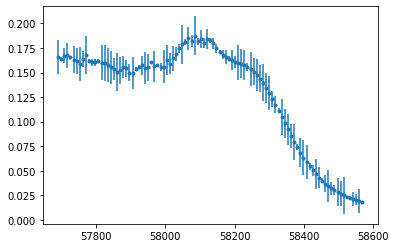

In [6]:
plt.errorbar(x_test,y_test,y_err,fmt='.')

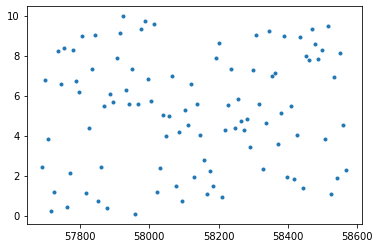

In [7]:
plt.plot(x_test,test,'.')

In [8]:
#Interpolation function used in model to obtain comparison points with data 
def interpolate(x0, y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [9]:
#locate index of points closest to data in conditional
n_new = 49
X_new = np.linspace(min(XJ), max(XJ), n_new)
idx=np.zeros(len(XJ),int)

for i in range(len(XJ)):
    idx[i] = np.argmin(((X_new - XJ[i])**2))
    
X_new[idx]-XJ
#idx

nf = 99
Xf = np.linspace(min(XJ), max(XJ), nf)
print((XJ[-1]-XJ[0])/3)

[293.07465733]


In [14]:
with pm.Model() as simpleconvmodel:
    
    #define driving function as Gaussian Process
    #find way to use g band as first guess of value 
    #what is the variation timescale of the driving function???
    ℓ = pm.Bound(pm.Normal, lower=0.0, upper=10.0)('ℓ',mu=np.sqrt(5.0/2.0),sigma=5.0)#timescale of variation for the driving function, order of days for x-ray
    #REMEMBER time scale is 2*ℓ^2 so remember to rewrite as ℓ_true=2*ℓ^2
    #in our case the lower bound is 1=2*l_lower² so l_lower=1/sqrt(2) or around 0.7
    η = pm.Uniform('η', lower=2.0, upper=10.0)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#using same cov as light curve interpolation
    #const_func = pm.gp.mean.Constant(tt.mean(yJ))#long term mean. Should it be zero or the g-band value?
    gp = pm.gp.Latent(cov_func=cov)
    
    #define "anchor points" using gp prior 

    f = gp.prior("f", X=Xf)#has all time values for all bands, testval is for g-band diffmag values?
    f = f.reshape((1,1,len(Xf),1))
    
    #create conditional distribution to find comparison points
    #f_sim = gp.conditional("f_sim", XJ)
    #fJ = f_sim#pm.sample_posterior_predictive(tracesimple, vars=[f_sim], samples=1)#f_sim
    #fJ=fJ.reshape((1,1,len(X_new),1))
    #print(fJ.tag.test_value)
    
    #Define priors
    
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.Bound(pm.Normal, lower=0.0)('sigma_DT',mu=2.0,sigma=2.0)#pm.Uniform('sigma_DT', lower=tt.log(1.01), upper=tt.log(30.0))#needs a source for scale
    m_DT=pm.Uniform('m_DT', lower=20.0, upper=75.0)#we expect serveral tens to hundreds of days from the nature letter
    theta_DT=0.0#pm.Uniform('theta_DT', lower=0.0, upper=np.max(tau)/1.2)#add later when simple model is staple
    
    #Accretion Disk paramters
    Jsigma_AD=pm.Bound(pm.Normal, lower=0.0)('Jsigma_AD',mu=2.0,sigma=2.0)# Shappee 2014 suggests somewhere between 0-30 days so log that 
    Jtheta_AD=0.0#pm.Normal('Jtheta_AD',mu=0.0,sigma=50.0)#pm.Uniform('Jtheta_AD', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later 
    Jm_lower=((m_DT+theta_DT)/5.0)-Jtheta_AD
    Jm_upper=((m_DT+theta_DT)/3.0)-Jtheta_AD
    Jm_AD=pm.Uniform('Jm_AD', lower=Jm_lower, upper=Jm_upper)#AD has 3-5 times smaller lags than DT 
    
    #BB and power law parameters
    T=pm.Bound(pm.Normal, lower=tt.log(1000.0), upper=tt.log(2300.0))('T', mu=tt.log(1400.0), sigma=0.22)#pm.Uniform('T', lower=tt.log(1000.0), upper=tt.log(2000.0))#pm.Bound(pm.Normal, lower=1000.0, upper=2000.0)('T', mu=1400.0, sigma=100.0)#taken from nature letter
    K_0=pm.Uniform('K_0', lower=0.0, upper=10.0)#is it BB/powr or powr/BB?
    index=pm.Normal('index', mu=1.5, sigma=0.5)#sign depends on diffmag definition change to -2 to -1 for final?
    #Note for index: we have taken the transformation from F_nu to F_lamb into account with the index value.

    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm NEED DATASHEET
    Jwav=1250.0
    
    #Define constants 
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/tt.exp(T)
    b_max = 4.967#h*c/(1e-9*wav_peak*k*tt.exp(T))
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*tt.exp(T))
    JBB = (1.0/( Jwav**5 * (tt.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((tt.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    Jlognorm_AD = tt.switch(tt.isnan(Jlognorm_AD), 0.0, Jlognorm_AD)
    JPsi_AD = Jpowr*Jlognorm_AD

    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    Jtransfer = Jtransfer.reshape(((1,1,len(tau),1)))
    #The convolutions
    #filter needs to be odd so tau is odd
    Jconvol=theano.tensor.nnet.conv2d(f[:,:,:,:],Jtransfer,border_mode='half')
    ######################################################################
    #'half': pad input with a symmetric border of filter rows // 2
    #rows and filter columns // 2 columns, then perform a valid convolution. 
    #For filters with an odd number of rows and columns, 
    #this leads to the output shape being equal to the input shape.
    ######################################################################
    
    #locate comparison points through interpolation
    comp=interpolate(Xf[:,0],Jconvol[0,0,:,0],x_test)
    
    #Define likelihood
    k = pm.Bound(pm.Normal, lower=0.0)('k',mu=1.0,sigma=1.0)#Noise boost factor 
    Jlikelihood = pm.Normal('yJ', mu=comp, sigma=k*y_err, observed=y_test)
    
    #the shape of mu and observed needs to be the same 
    
    #max_treedepth, default=10
    #The maximum tree depth. Trajectories are stopped when this depth is reached.
    #early_max_treedepth, default=8
    #The maximum tree depth during the first 200 tuning samples.

    tracesimple = pm.sample(4000,tune=1000,init='advi+adapt_diag',chains=2,cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
  0%|          | 0/200000 [00:00<?, ?it/s]/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = -1,945.1:  17%|█▋        | 34352/200000 [01:09<05:36, 492.39it/s]  
Convergence achieved at 34400
Interrupted at 34,399 [17%]: Average Loss = 5.9193e+08
/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a dif

In [17]:
simplenames=['sigma_DT','m_DT','Jsigma_AD','Jm_AD','T','K_0','index', 'η', 'ℓ','k']
summ=pm.summary(tracesimple,simplenames)
#print(summ.loc[:,'mean'])
summ

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_DT,0.619,0.114,0.513,0.828,0.074,0.060,2.0,2.0,3.0,39.0,2.00
m_DT,74.663,0.359,74.041,75.000,0.076,0.055,22.0,22.0,39.0,42.0,1.04
Jsigma_AD,0.708,0.283,0.381,1.172,0.176,0.142,3.0,3.0,3.0,31.0,1.93
Jm_AD,20.306,3.176,14.970,24.512,1.727,1.345,3.0,3.0,4.0,26.0,1.42
T,7.505,0.150,7.253,7.740,0.082,0.064,3.0,3.0,4.0,29.0,1.47
K_0,0.048,0.037,0.013,0.130,0.021,0.017,3.0,3.0,4.0,13.0,1.55
index,1.489,0.495,0.570,2.422,0.011,0.008,1894.0,1894.0,1895.0,3446.0,1.00
η,8.013,1.878,4.520,10.000,1.059,0.857,3.0,3.0,3.0,20.0,1.57
ℓ,8.432,1.272,6.114,10.000,0.207,0.155,38.0,34.0,35.0,1099.0,1.05
k,22.788,0.153,22.497,23.066,0.003,0.002,2312.0,2312.0,2319.0,3341.0,1.00


In [ ]:
sigma_DT=       0.324
m_DT     =     54.116
theta_DT  =   0.0
Jsigma_AD  =    2.175
Jtheta_AD   =  0.0
Jm_AD        = 68.891
T             = np.exp(7.421)
K_0            =0.838
index          =1.148

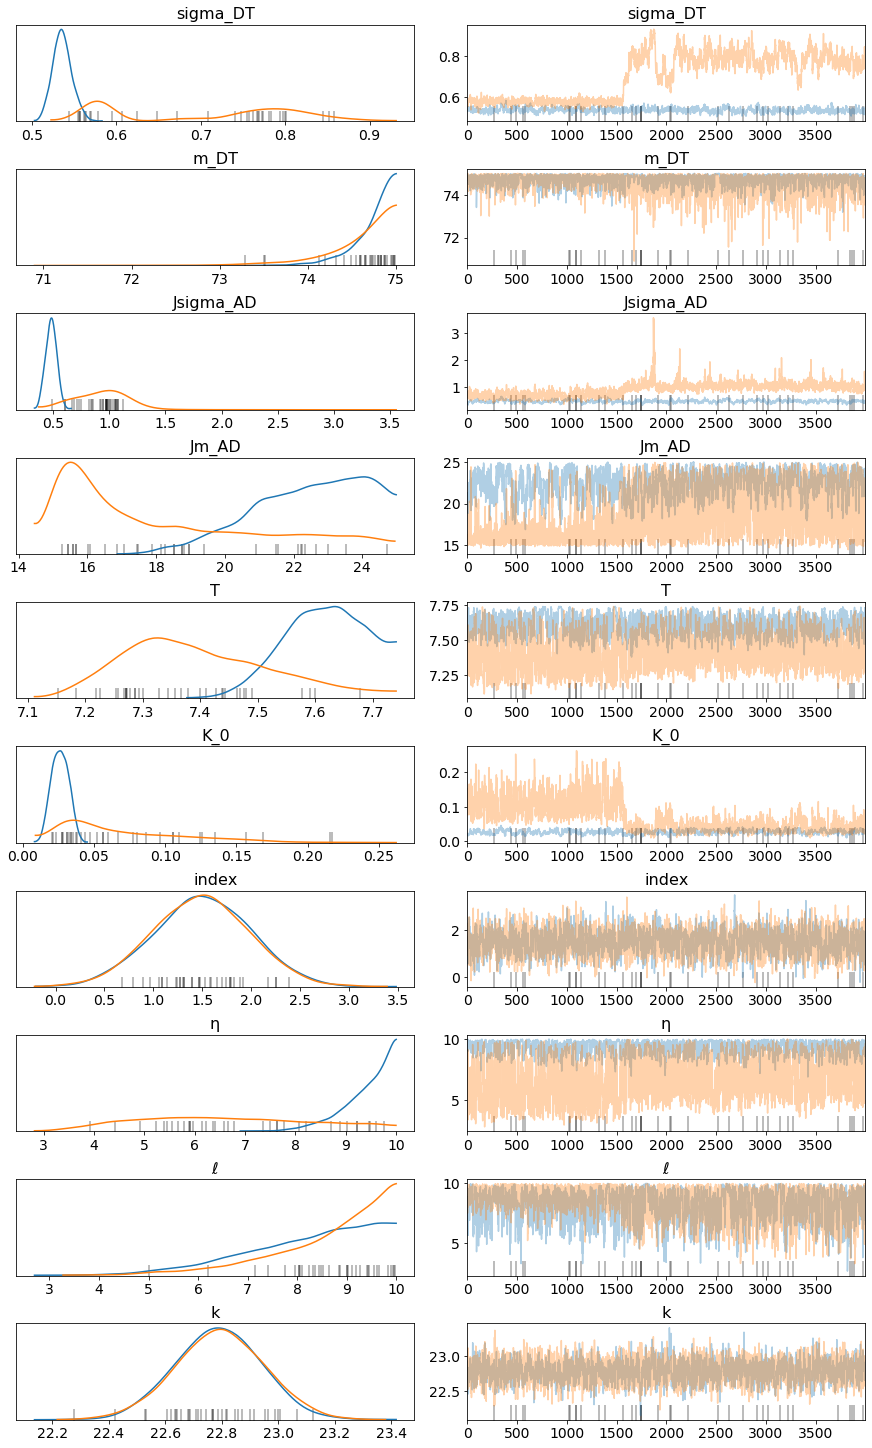

In [18]:
pm.traceplot(tracesimple, var_names=simplenames);

In [24]:
tracesimple.nchains

2